In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-05-26 18:28:38.249319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_mfcc(mfcc, fs):
    plt.figure(figsize=(12,6))
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    plt.title('MFCCs')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()


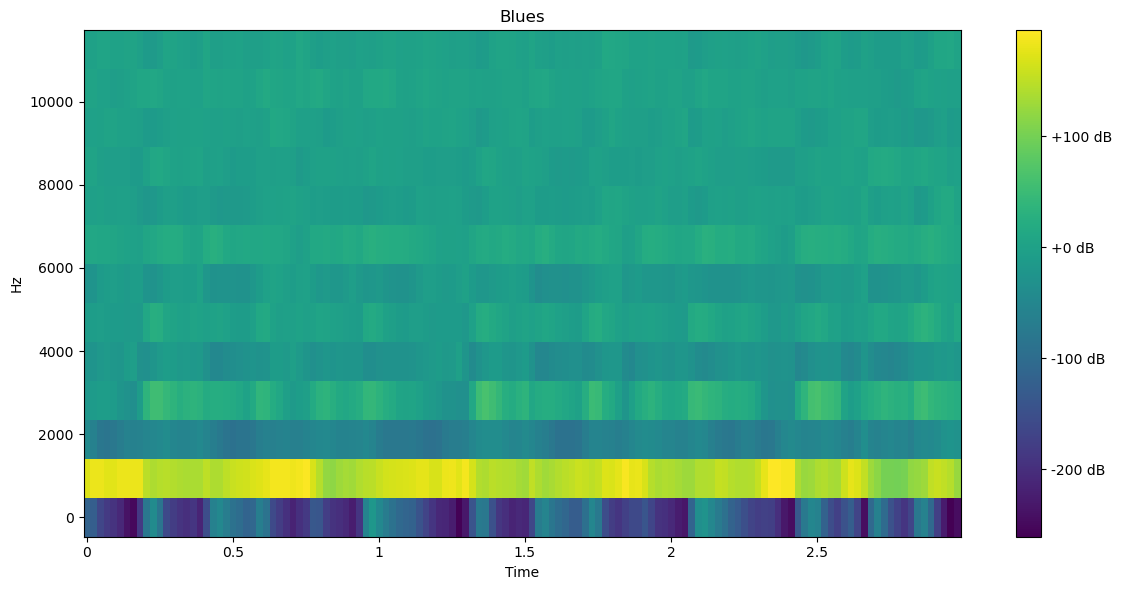

In [3]:
path="/home/efectn/python-music-classification"
json_path = path+"/dataset/features_3.0_sec.json"

with open(json_path, "r") as fp:
    data = json.load(fp)

idx = 100
fs = 22500

mfcc_sample = np.array(data["mfcc"])[idx].T
plot_mfcc(mfcc_sample, fs)

if "genre_name" in data:
    plt.title(f"{np.array(data['genre_name'])[idx].title()}")
else:
    plt.title(f"Sample #{idx}")

In [4]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

print("MFCC şekli:", X.shape)
print("Etiket şekli:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print("Eğitim verisi şekli:", X_train.shape)
print("Doğrulama verisi şekli:", X_val.shape)

MFCC şekli: (9989, 132, 13)
Etiket şekli: (9989,)
Eğitim verisi şekli: (5593, 132, 13)
Doğrulama verisi şekli: (1399, 132, 13)


In [5]:
model_lstm = Sequential()

model_lstm.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(10, activation='softmax'))

model_lstm.compile(loss='sparse_categorical_crossentropy',
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   metrics=['accuracy'])

model_lstm.summary()

2025-05-26 18:30:35.799223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 132, 128)          72704     
                                                                 
 dropout (Dropout)           (None, 132, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                6

In [6]:
from tensorflow.python.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)

history = model_lstm.fit(X_train, y_train,
                         validation_data=(X_val, y_val),
                         epochs=100,
                         batch_size=32,
                         verbose=1,
                         callbacks=[early_stop, reduce_lr],
                         )

Epoch 1/100
175/175 [==============================] - 18s 91ms/step - loss: 2.2337 - accuracy: 0.1629 - val_loss: 2.0838 - val_accuracy: 0.2909 - lr: 1.0000e-04
Epoch 2/100
175/175 [==============================] - 16s 89ms/step - loss: 2.0497 - accuracy: 0.2705 - val_loss: 1.8462 - val_accuracy: 0.3753 - lr: 1.0000e-04
Epoch 3/100
175/175 [==============================] - 15s 84ms/step - loss: 1.8502 - accuracy: 0.3465 - val_loss: 1.6333 - val_accuracy: 0.4403 - lr: 1.0000e-04
Epoch 4/100
175/175 [==============================] - 15s 85ms/step - loss: 1.7066 - accuracy: 0.3933 - val_loss: 1.4996 - val_accuracy: 0.4961 - lr: 1.0000e-04
Epoch 5/100
175/175 [==============================] - 15s 87ms/step - loss: 1.5917 - accuracy: 0.4286 - val_loss: 1.4223 - val_accuracy: 0.5054 - lr: 1.0000e-04
Epoch 6/100
175/175 [==============================] - 15s 88ms/step - loss: 1.5018 - accuracy: 0.4701 - val_loss: 1.3324 - val_accuracy: 0.5318 - lr: 1.0000e-04
Epoch 7/100
175/175 [=======

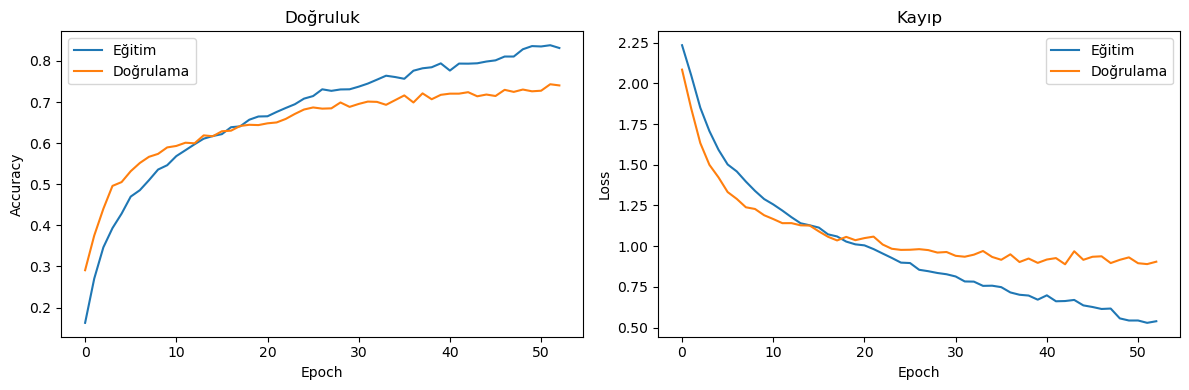

In [7]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Eğitim")
plt.plot(history.history["val_accuracy"], label="Doğrulama")
plt.title("Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Eğitim")
plt.plot(history.history["val_loss"], label="Doğrulama")
plt.title("Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 20ms/step


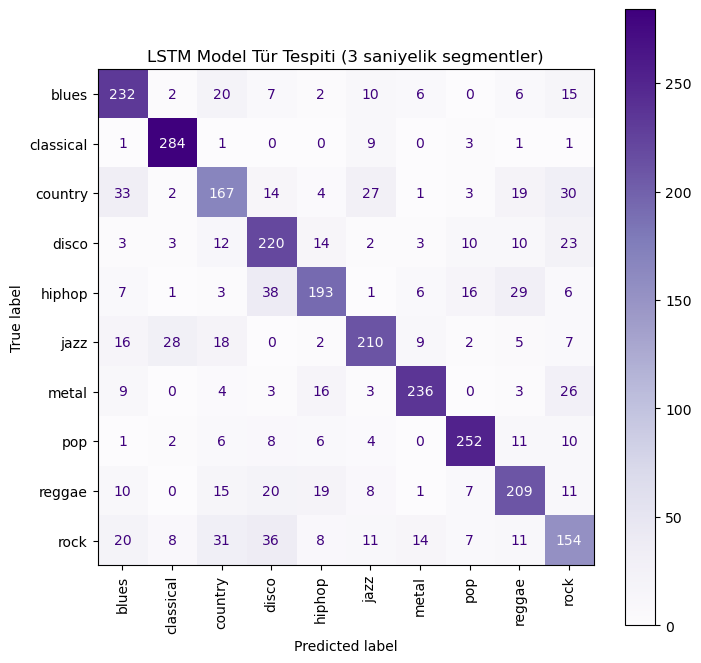

In [8]:
def make_prediction(model, X):
    global genres
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1)
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])

    return preds_num, preds_name

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

preds_num, preds_name = make_prediction(model_lstm, X_test)
cm = confusion_matrix(y_test, preds_num)

fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap='Purples', xticks_rotation='vertical')
plt.title('LSTM Model Tür Tespiti (3 saniyelik segmentler)')
plt.show()

In [9]:
model_lstm.save(os.path.join(path, "models/model_lstm.h5"))